# Confidence Intervals with T Distribution - Lab

## Introduction

In the previous lab, we saw that if we have the standard deviation for the population, we can use use $z$-score to calculate our confidence interval using the mean of sample means. 

If, on the other hand, the standard deviation of the population is not known (which is usually the case), you have to use the standard deviation of your sample as a stand-in when creating confidence intervals. Since the sample standard deviation is often different than that of the population, further potential errors are introduced to our confidence intervals. To account for this error, we use what's known as a t-critical value instead of the $z$-critical value.

The t-critical value is drawn from what's known as a t-distribution.
> A t-distribution  closely resembles the normal distribution but gets wider and wider as the sample size falls.

<img src="https://raw.githubusercontent.com/learn-co-curriculum/dsc-intervals-with-t-distribution-lab/master/images/new_t-distr-img.png" alt="comparison of t and z distributions" width="500">

The t-distribution is available in `scipy.stats` with the nickname "t" so we can get t-critical values with `stats.t.ppf()`.

## Objectives

You will be able to:

* Calculate confidence intervals using the t-distribution
* Interpret confidence intervals in relation to true population parameters

## Let's Get Started!

In [1]:
# Import the necessary libraries

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math

Let's investigate point estimates by generating a population of random age data collected at two different locations and then drawing a sample from it to estimate the mean:

,Age
count,20000.000000
mean,21.008578
std,3.671277
min,4.784588
25%,18.662256
50%,21.163276
75%,23.489438
max,36.140116


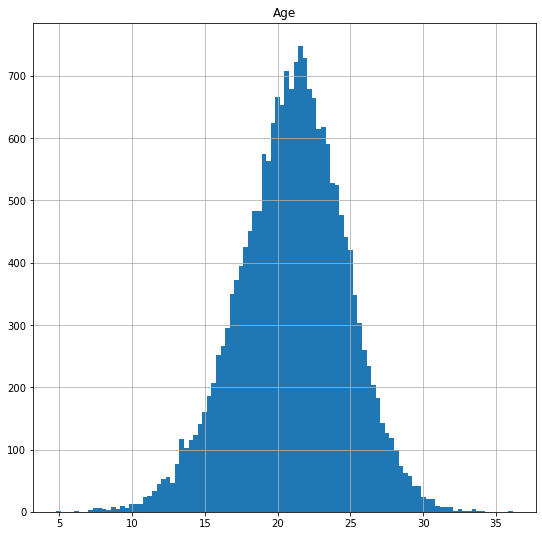

In [2]:
np.random.seed(20)
population_ages1 = np.random.normal(20, 4, 10000) 
population_ages2 = np.random.normal(22, 3, 10000) 
population_ages = np.concatenate((population_ages1, population_ages2))

pop_ages = pd.DataFrame(population_ages, columns=["Age"])
pop_ages.hist(bins=100, figsize=(9,9))
pop_ages.describe()

**Important note:** If we actually had access to the full population data represented above, we would not need to calculate a confidence interval around the mean using sample data. We are taking a sample and calculating a confidence interval for demonstration purposes

### Creating a Sample

Let's take a new, smaller sample (of size smaller than 30) and calculate how much the sample mean differs from the population mean.

In [3]:
np.random.seed(23)

sample_size = 25
# Take a random sample of size 25 from above population
sample = np.random.choice(a=population_ages, size=sample_size)
# Calculate sample mean
sample_mean = sample.mean()
# Calculate population mean
population_mean = population_ages.mean()

# Print sample mean and difference of sample and population mean 
print ("Sample Mean:", sample_mean)
print ("Mean Difference:", population_mean - sample_mean)

Sample Mean: 19.870788629471857
Mean Difference: 1.1377888781920937


We can see that the sample mean differs from the population mean by 1.13 years. Recall that the purpose of calculating a confidence interval is attempting to capture the true population parameter (population mean) without having access to the full population data.

## Calculating the Confidence Interval "By Hand"

### Finding the Critical Value

For the sake of example, let's say that we are calculating the confidence interval solely based on information in the sample. In other words, unlike when we calculated confidence intervals using the **z-distribution**, we do not have the population standard deviation.

We can calculate a confidence interval without the population standard deviation using the **t-distribution**, represented by the `stats.t.ppf(q, df)` function. This function takes in a value for the confidence level required (`q`) with "degrees of freedom" (`df`).

Hints:
- In this case, we want 95% confidence level for a two-tail test. This means the confidence level (`q`) for this function needs to be $(1-0.95)/2$, i.e. $0.975$
- In this case, the number of degrees of freedom (`df`) is equal to the sample size minus 1, or `df = sample_size - 1`. 

Calculate the t-critical value for a 95% confidence level based on the sample taken above.

In [4]:

# Get the t-critical value
t_critical = stats.t.ppf(q=0.975, df=sample_size-1)

# Check the t-critical value
print("t-critical value:")
print(t_critical)     

t-critical value:
2.0638985616280205


### Finding the Standard Error of the Mean

The standard error of the mean is $\dfrac{S}{\sqrt{n}}$, where $S$ is the sample standard deviation and $n$ is the sample size.

Calculate the standard error of the mean for `sample` below.

In [5]:

# Get the sample standard deviation
sample_stdev = sample.std(ddof=1)

# Calculate the standard error using the formula described above
se = sample_stdev/math.sqrt(sample_size)

# Check the SE
print("Sample Standard Error of the Mean:")
print(se)

Sample Standard Error of the Mean:
0.697197803193802


### Finding the Margin of Error and Confidence Interval

The margin of error is $t_{\alpha/2,n-1}\left(\dfrac{S}{\sqrt{n}}\right)$, i.e. the t-critical value times the standard error.

Then the confidence interval is $\bar{x}\pm t_{\alpha/2,n-1}\left(\dfrac{S}{\sqrt{n}}\right)$, i.e. a tuple containing:
- The sample mean minus the margin of error
- The sample mean plus the margin of error

Calculate both in the cell below.

In [6]:

# Calculate margin of error using t_critical and se
margin_of_error = t_critical * se

# Calculate the confidence interval using margin_of_error
confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)

# Check the confidence interval
print("Confidence Interval:")
print(confidence_interval)

Confidence Interval:
(18.431843086289952, 21.309734172653762)


### Verifying Our Results with `stats.t.interval`

The previous exercise walked through each of the parts of calculating the confidence interval in order to reinforce your understanding of the formula. However, as you may recall from the previous lesson, there is a function within SciPy that will perform a lot of the same logic with a single function call!

Let's verify our calculations by using the Python function `stats.t.interval()`:

In [7]:

ci = stats.t.interval(
    confidence=0.95,         # Confidence level
    df=sample_size - 1, # Degrees of freedom
    loc=sample_mean,    # Sample mean
    scale=se            # Standard error
)

print("True Population Mean:")
print(population_mean)
print("95% Confidence Interval of Mean Based on Sample:")
print(ci)

True Population Mean:
21.00857750766395
95% Confidence Interval of Mean Based on Sample:
(18.431843086289952, 21.309734172653762)


Going forward, if you know that the confidence interval is the desired end result, you can just use the above function instead of calculating the critical t and margin of error "by hand".

### Interpreting the Confidence Interval

We can see that the calculated confidence interval (`ci`) includes the true population mean (`population_mean`) calculated above. Since we generated a 95% confidence interval, we would expect that, if we repeatedly drew samples and calculated confidence intervals in the same way, the true population mean would be present within 95% of the confidence intervals we would calculate.

We will illustrate (and visualize!) this point below.

## Confidence Intervals of Repeated Samples

Let's run the code multiple times to see how often our estimated confidence interval covers the population mean value:

**Refactor the code above into a function called `conf_interval` that takes in sample data and returns a confidence interval for the population mean.**

The starter code is below, and we have used slightly different variable names to represent the same concepts.

In [8]:

def conf_interval(sample):
    '''
    Input:  Sample data
    Output: Confidence interval for the mean of the
            population that the sample was drawn from
    '''
    
    # Sample size
    n = len(sample)
    # Sample mean
    x_hat = sample.mean()
    
    # Standard error of the mean
    standard_error = sample.std(ddof=1)/math.sqrt(n) 
    
    # Compute confidence interval with stats.t.interval
    conf = stats.t.interval(
        confidence=0.95,
        df=n - 1,
        loc=x_hat,
        scale=standard_error
    )
    
    return conf

# Confirm that this produces the same interval as the previous code
conf_interval(sample)

(18.431843086289952, 21.309734172653762)

Now we can test out what happens if we repeatedly take samples from the same population.

**Call the function 20 times, taking different samples at each iteration and calculating the sample mean and confidence intervals**

Hints:
- `sample_means` should be a list of numbers
- `intervals` should be a list of tuples (each tuple containing two numbers)

In [9]:

# Set random seed for reproducibility
np.random.seed(12)

# Select the sample size 
sample_size = 25

# Initialize lists to store interval and mean values
sample_means = []
intervals = []

# Run a for loop for sampling 20 times and calculate + store 
# confidence interval and sample mean values in lists initialized above
for sample in range(20):
    # Take a random sample of chosen size from population_ages
    sample = np.random.choice(a=population_ages, size=sample_size)
    
    # Calculate sample mean and confidence_interval
    sample_mean = sample.mean()
    confidence_interval = conf_interval(sample)    

    # Append sample means and conf intervals for each iteration
    sample_means.append(sample_mean)
    intervals.append(confidence_interval)


**Use the code below to plot the confidence intervals along with the sample means and population mean**

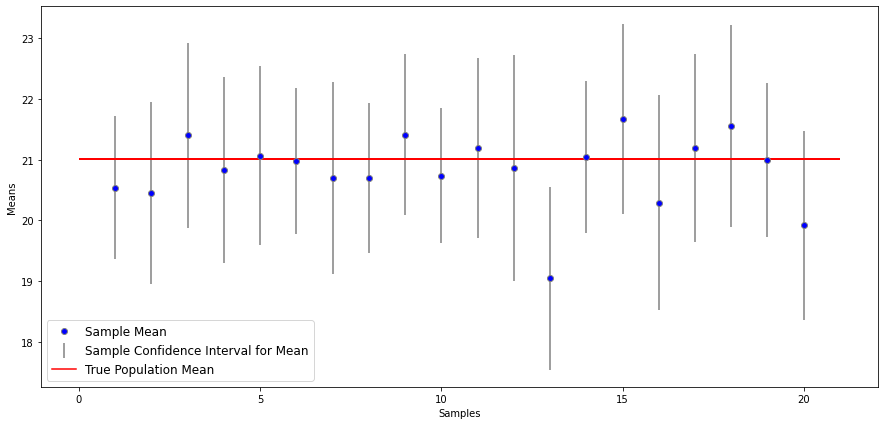

In [10]:

# Set up figure
fig, ax = plt.subplots(figsize=(15,7))

# Draw the means and confidence intervals for each sample
ax.errorbar(
    x=np.arange(1, 21, 1),
    y=sample_means,
    yerr=[abs(upper-lower)/2 for upper, lower in intervals],
    fmt='o',
    color="gray",
    markerfacecolor="blue"
)

# Draw the population mean as a horizontal line 
ax.hlines(
    xmin=0,
    xmax=21,
    y=population_ages.mean(), 
    linewidth=2.0,
    color="red"
)

# Label plot
ax.set_xlabel("Samples")
ax.set_ylabel("Means")

# Customize legend appearance
legend_elements = [
    # Sample mean (blue circle with gray edge)
    Line2D(
        [0], # "Dummy" line being graphed
        [0], # for use in the legend
        marker="o",
        color="w",
        markerfacecolor="blue",
        markeredgecolor="gray"
    ),
    # Confidence interval (gray vertical line)
    Line2D(
        [0],
        [0],
        marker="|",
        markersize=15,
        color="w",
        markeredgewidth=1.5,
        markeredgecolor="gray"
    ),
    # Population mean (red horizontal line)
    Line2D([0],[0], color="red")
]

ax.legend(
    handles=legend_elements,
    labels=["Sample Mean", "Sample Confidence Interval for Mean", "True Population Mean"],
    loc="lower left", 
    fontsize="large"
);

### Interpreting Confidence Intervals of Repeated Samples

Just like the last lab, all but one of the 95% confidence intervals overlap the red line marking the true mean. This is to be expected: since we're generating a 95% confidence interval, we would expect after repeatedly sampling and calculating confidence intervals that 95% of the confidence intervals calculated would contain the true population mean, while 5% would not.

It won't always turn out at exactly 1 out of 20 like this (just like flipping a coin twice won't always give you 1 heads and 1 tails), but this particular example turned out nicely.

## Summary

In this lab, we learned how to use confidence intervals when the population standard deviation is not known, and the sample size is small (<30). Specifically, we constructed confidence intervals "by hand" using the t-critical value and margin of error, then saw how to use `stats.t.interval` instead. We also demonstrated an example of multiple samples being taken and confidence intervals being calculated, and how this relates to the 95% confidence level. 